In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sklearn
import tensorflow as tf
from collections import Counter

%matplotlib inline

/home/samuel/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# uncomment the group you want to train on
race = "hispanic"
#race = "white"
#race = "mixed"

In [3]:
X = np.load('../Data/' + race + '/X.npy')
Y2 = np.load('../Data/' + race + '/Y2.npy')

In [4]:
size_hispanic = 37575

In [5]:
X.shape

(37575, 301)

In [5]:
# shuffle
np.random.seed(42)
idx = np.random.permutation(len(X))
X = X[idx]
Y = Y2[idx]

#if race != 'hispanic':
#   X = X[:size_hispanic]
#    Y = Y[:size_hispanic]

TEST_SET_SIZE = int(0.1*len(Y))

X_train, X_test = X[:-TEST_SET_SIZE], X[-TEST_SET_SIZE:]
Y_train, Y_test = Y[:-TEST_SET_SIZE].astype(int), Y[-TEST_SET_SIZE:].astype(int)

In [7]:
X.shape

(37575, 301)

In [6]:
# Features Scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
std_scaler = StandardScaler()
X_train[:,-4:] = std_scaler.fit_transform(X_train[:,-4:])
X_test[:,-4:] = std_scaler.transform(X_test[:,-4:])

mm_scaler = MinMaxScaler(feature_range=(-1,1))
X_train[:,:-4] = mm_scaler.fit_transform(X_train[:,:-4])
X_test[:,:-4] = mm_scaler.transform(X_test[:,:-4])

/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [7]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.metrics import confusion_matrix

def results(classifier,threshold=0.5, X_test=X_test, Y_test=Y_test):
    Y_pred_test = classifier.predict(X_test)
    Y_pred_test = (Y_pred_test>=threshold).astype(int)
    #Y_pred_test = np.rint(Y_pred_test)
    print("Test accuracy score: " + str(accuracy_score(Y_test.astype(int), Y_pred_test)))
    print("ROC: " + str(roc_auc_score(Y_test, classifier.predict(X_test))))
    #print("ROC: " + str(roc_auc_score(Y_test, Y_pred_test)))
    matrix = confusion_matrix(Y_test.astype(int), Y_pred_test)
    tn, fp, fn, tp = matrix.ravel()
    ppv = tp/(tp+fp)
    npv = tn/(tn+fn)
    sensitivity = tp/(tp+fn)
    specificity = tn/(tn+fp)
    g_mean = np.sqrt(sensitivity*specificity)
    print("PPV: " + str(ppv))
    print("NPV: " + str(npv))
    print("Sensitivity: " + str(sensitivity))
    print("Specificity: " + str(specificity))
    print("G-Mean: " + str(g_mean))
    print("Confusion matrix:\n" + str(matrix))
    
    return str(roc_auc_score(Y_test, classifier.predict(X_test)))[:6], str(sensitivity)[:6], str(specificity)[:6], str(g_mean)[:6]

## Undersample

In [89]:
from imblearn.under_sampling import RandomUnderSampler
us = RandomUnderSampler(ratio=1.0)
X_train_res, Y_train_res = us.fit_sample(X_train, Y_train)

/home/samuel/anaconda3/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
Counter(Y_train)

Counter({0: 6095, 1: 27723})

In [9]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import regularizers
from keras.layers import Conv1D, MaxPooling1D, Flatten

Using TensorFlow backend.


## ConvNet

In [ ]:
var_layers = 2
#var_act_maps = 2
#var_kernel_size = 10
#var_dense_layer = 100


for var_act_maps in [2,4,8,16]:
    for var_kernel_size in [10,20,50,100,150]:
        for var_dense_layer in [25,50,100,200,300]:
            model = Sequential()
            model.add(Conv1D(var_act_maps, kernel_size=var_kernel_size, strides=1,
                             activation='relu', padding="same",
                             input_shape=(X_train.shape[1],1), name='layer1'))
            #model.add(MaxPooling1D(pool_size=2, strides=None))
            model.add(Dropout(0.2))
            model.add(Conv1D(var_act_maps*2, kernel_size=var_kernel_size, strides=1,
                 activation='relu', padding="same",
                 input_shape=(X_train.shape[1],1), name='layer2'))
            ''''
            
            model.add(Conv1D(var_act_maps*2, kernel_size=var_kernel_size, strides=1,
             activation='relu', padding="same",
             input_shape=(X_train.shape[1],1), name='layer3'))
            '''
            model.add(Flatten())
            model.add(Dense(var_dense_layer, activation='relu'))
            model.add(Dense(1, activation='sigmoid'))


            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            model.fit(X_train.reshape((-1, X_train.shape[1],1)), Y_train, epochs=10, batch_size=200,)
            scores = model.evaluate(X_test.reshape(-1,X_test.shape[1],1), Y_test)
            print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))
            o1, o2, o3, o4 = results(model, X_test=X_test.reshape(-1,X_test.shape[1],1))
            fd = open('dropout_results.csv','a')
            output_arr = [var_layers, var_act_maps, var_kernel_size, var_dense_layer, o1, o2, o3, o4]
            fd.write(','.join(map(str,output_arr))+'\n')
            fd.close()

Epoch 1/10
33818/33818 [==============================] - 16s 474us/step - loss: 0.3972 - acc: 0.8328
Epoch 2/10
33818/33818 [==============================] - 4s 105us/step - loss: 0.3386 - acc: 0.8519
Epoch 3/10
33818/33818 [==============================] - 4s 107us/step - loss: 0.3317 - acc: 0.8534
Epoch 4/10
33818/33818 [==============================] - 4s 105us/step - loss: 0.3326 - acc: 0.8539
Epoch 5/10
33818/33818 [==============================] - 4s 107us/step - loss: 0.3300 - acc: 0.8546
Epoch 6/10
33818/33818 [==============================] - 4s 107us/step - loss: 0.3283 - acc: 0.8556
Epoch 7/10
33818/33818 [==============================] - 4s 106us/step - loss: 0.3274 - acc: 0.8572
Epoch 8/10
33818/33818 [==============================] - 4s 106us/step - loss: 0.3260 - acc: 0.8592
Epoch 9/10
33818/33818 [==============================] - 4s 107us/step - loss: 0.3248 - acc: 0.8572
Epoch 10/10
3757/3757 [==============================] - 7s 2ms/step

acc: 85.49%
Test acc

33818/33818 [==============================] - 4s 130us/step - loss: 0.3339 - acc: 0.8533
Epoch 4/10
33818/33818 [==============================] - 4s 130us/step - loss: 0.3323 - acc: 0.8541
Epoch 5/10
33818/33818 [==============================] - 4s 129us/step - loss: 0.3283 - acc: 0.8558
Epoch 6/10
33818/33818 [==============================] - 4s 130us/step - loss: 0.3265 - acc: 0.8562
Epoch 7/10
33818/33818 [==============================] - 4s 130us/step - loss: 0.3266 - acc: 0.8569
Epoch 8/10
33818/33818 [==============================] - 4s 130us/step - loss: 0.3253 - acc: 0.8560
Epoch 9/10
33818/33818 [==============================] - 4s 131us/step - loss: 0.3239 - acc: 0.8585
Epoch 10/10
3757/3757 [==============================] - 7s 2ms/step

acc: 85.39%
Test accuracy score: 0.8538727708277881
ROC: 0.8686312183713968
PPV: 0.8929786575935663
NPV: 0.6125954198473282
Sensitivity: 0.934304207119741
Specificity: 0.48125937031484256
G-Mean: 0.6705539906681302
Confusion matrix:
[

33818/33818 [==============================] - 7s 207us/step - loss: 0.3300 - acc: 0.8550
Epoch 6/10
33818/33818 [==============================] - 7s 207us/step - loss: 0.3300 - acc: 0.8550
Epoch 7/10
33818/33818 [==============================] - 7s 206us/step - loss: 0.3281 - acc: 0.8561
Epoch 8/10
33818/33818 [==============================] - 7s 207us/step - loss: 0.3272 - acc: 0.8552
Epoch 9/10
33818/33818 [==============================] - 7s 206us/step - loss: 0.3256 - acc: 0.8576
Epoch 10/10
3757/3757 [==============================] - 7s 2ms/step

acc: 85.47%
Test accuracy score: 0.8546712802768166
ROC: 0.8698281926997666
PPV: 0.8918669131238447
NPV: 0.6183953033268101
Sensitivity: 0.9368932038834952
Specificity: 0.4737631184407796
G-Mean: 0.6662322762504214
Confusion matrix:
[[ 316  351]
 [ 195 2895]]
Epoch 1/10
33818/33818 [==============================] - 20s 595us/step - loss: 0.3608 - acc: 0.8433
Epoch 2/10
33818/33818 [==============================] - 7s 214us/step - 

Epoch 7/10
33818/33818 [==============================] - 12s 368us/step - loss: 0.3271 - acc: 0.8558
Epoch 8/10
33818/33818 [==============================] - 12s 365us/step - loss: 0.3261 - acc: 0.8567
Epoch 9/10
33818/33818 [==============================] - 12s 370us/step - loss: 0.3247 - acc: 0.8571
Epoch 10/10
3757/3757 [==============================] - 8s 2ms/step

acc: 85.49%
Test accuracy score: 0.8549374500931595
ROC: 0.8672668520108877
PPV: 0.8885496183206106
NPV: 0.6265560165975104
Sensitivity: 0.941747572815534
Specificity: 0.4527736131934033
G-Mean: 0.6529919228136034
Confusion matrix:
[[ 302  365]
 [ 180 2910]]
Epoch 1/10
33818/33818 [==============================] - 26s 765us/step - loss: 0.3731 - acc: 0.8394
Epoch 2/10
33818/33818 [==============================] - 13s 370us/step - loss: 0.3389 - acc: 0.8502
Epoch 3/10
33818/33818 [==============================] - 13s 370us/step - loss: 0.3365 - acc: 0.8518
Epoch 4/10
33818/33818 [==============================] - 1

33818/33818 [==============================] - 19s 557us/step - loss: 0.3264 - acc: 0.8558
Epoch 9/10
33818/33818 [==============================] - 19s 559us/step - loss: 0.3256 - acc: 0.8581
Epoch 10/10
3757/3757 [==============================] - 8s 2ms/step

acc: 85.39%
Test accuracy score: 0.8538727708277881
ROC: 0.8693920030276124
PPV: 0.8910433979686058
NPV: 0.6161417322834646
Sensitivity: 0.9368932038834952
Specificity: 0.46926536731634183
G-Mean: 0.6630622395043867
Confusion matrix:
[[ 313  354]
 [ 195 2895]]
Epoch 1/10
33818/33818 [==============================] - 18s 530us/step - loss: 0.3698 - acc: 0.8389
Epoch 2/10
33818/33818 [==============================] - 4s 125us/step - loss: 0.3400 - acc: 0.8497
Epoch 3/10
33818/33818 [==============================] - 4s 125us/step - loss: 0.3340 - acc: 0.8528
Epoch 4/10
33818/33818 [==============================] - 4s 125us/step - loss: 0.3315 - acc: 0.8545
Epoch 5/10
33818/33818 [==============================] - 4s 125us/step

3757/3757 [==============================] - 8s 2ms/step

acc: 85.28%
Test accuracy score: 0.8528080915624168
ROC: 0.8717117169570555
PPV: 0.8985234055922086
NPV: 0.5993031358885017
Sensitivity: 0.9255663430420712
Specificity: 0.5157421289355323
G-Mean: 0.6909077769366857
Confusion matrix:
[[ 344  323]
 [ 230 2860]]
Epoch 1/10
33818/33818 [==============================] - 20s 579us/step - loss: 0.3702 - acc: 0.8379
Epoch 2/10
33818/33818 [==============================] - 6s 168us/step - loss: 0.3374 - acc: 0.8496
Epoch 3/10
33818/33818 [==============================] - 6s 167us/step - loss: 0.3311 - acc: 0.8519
Epoch 4/10
33818/33818 [==============================] - 6s 167us/step - loss: 0.3291 - acc: 0.8560
Epoch 5/10
33818/33818 [==============================] - 6s 167us/step - loss: 0.3277 - acc: 0.8556
Epoch 6/10
33818/33818 [==============================] - 6s 167us/step - loss: 0.3259 - acc: 0.8578
Epoch 7/10
33818/33818 [==============================] - 6s 167us/step - l

ROC: 0.8709994517304454
PPV: 0.8921749845964264
NPV: 0.6203522504892368
Sensitivity: 0.9372168284789644
Specificity: 0.4752623688155922
G-Mean: 0.667400846565802
Confusion matrix:
[[ 317  350]
 [ 194 2896]]
Epoch 1/10
33818/33818 [==============================] - 26s 774us/step - loss: 0.3544 - acc: 0.8455
Epoch 2/10
33818/33818 [==============================] - 12s 344us/step - loss: 0.3343 - acc: 0.8525
Epoch 3/10
33818/33818 [==============================] - 12s 344us/step - loss: 0.3305 - acc: 0.8543
Epoch 4/10
33818/33818 [==============================] - 12s 343us/step - loss: 0.3266 - acc: 0.8579
Epoch 5/10
33818/33818 [==============================] - 12s 349us/step - loss: 0.3239 - acc: 0.8571
Epoch 6/10
33818/33818 [==============================] - 12s 347us/step - loss: 0.3223 - acc: 0.8591
Epoch 7/10
33818/33818 [==============================] - 12s 349us/step - loss: 0.3216 - acc: 0.8591
Epoch 8/10
33818/33818 [==============================] - 12s 347us/step - loss

In [13]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model.fit(X_train.reshape((-1, X_train.shape[1],1)), Y_train, epochs=10, batch_size=200,)

scores = model.evaluate(X_test.reshape(-1,X_test.shape[1],1), Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/10
33818/33818 [==============================] - 2s 47us/step - loss: 0.3781 - acc: 0.8409
Epoch 2/10
33818/33818 [==============================] - 1s 42us/step - loss: 0.3295 - acc: 0.8550
Epoch 3/10
33818/33818 [==============================] - 1s 42us/step - loss: 0.3255 - acc: 0.8576
Epoch 4/10
33818/33818 [==============================] - 1s 41us/step - loss: 0.3228 - acc: 0.8582
Epoch 5/10
33818/33818 [==============================] - 1s 38us/step - loss: 0.3208 - acc: 0.8593
Epoch 6/10
33818/33818 [==============================] - 1s 43us/step - loss: 0.3186 - acc: 0.8614
Epoch 7/10
33818/33818 [==============================] - 1s 41us/step - loss: 0.3171 - acc: 0.8614
Epoch 8/10
33818/33818 [==============================] - 1s 42us/step - loss: 0.3159 - acc: 0.8629
Epoch 9/10
33818/33818 [==============================] - 1s 42us/step - loss: 0.3133 - acc: 0.8634
Epoch 10/10
3757/3757 [==============================] - 0s 80us/step

acc: 85.23%


In [14]:
o1, o2, o3, o4 = results(model, X_test=X_test.reshape(-1,X_test.shape[1],1))
fd = open('conv_results.csv','a')
output_arr = [var_layers, var_act_maps, var_kernel_size, var_dense_layer, o1, o2, o3, o4]
fd.write(','.join(map(str,output_arr))+'\n')
fd.close()

Test accuracy score: 0.8522757519297312
ROC: 0.8667884504349768
PPV: 0.8851412944393802
NPV: 0.6201716738197425
Sensitivity: 0.9427184466019417
Specificity: 0.4332833583208396
G-Mean: 0.6391120515955667
Confusion matrix:
[[ 289  378]
 [ 177 2913]]


In [104]:
','.join(map(str,output_arr))

'1,2,10,25,0.8653755646448621,0.9313915857605178,0.49325337331334335,0.6777994110000684'

In [43]:
from keras import backend as K
get_1st_layer_output = K.function([model.layers[0].input],
                                  [model.layers[1].output])
#layer_output = get_1st_layer_output([X])

In [47]:
layer_output = get_1st_layer_output([X_test[0].reshape(-1,301,1)])


In [62]:
l1 = model.get_layer("layer1")
l1.get_weights()[0].ravel()

array([-0.39937037, -0.25302196, -0.33779934, -0.37349048,  0.6447491 ,
        0.5206269 ,  0.27678737,  0.48182878,  0.12258197, -0.25269464,
        0.02413214, -0.06378173,  0.22032526, -0.05318109, -0.21164675,
        0.4822819 , -0.28148416, -0.3359999 ,  0.57592595, -0.11844412],
      dtype=float32)

In [52]:
layer_output[0]

array([[[0.29736763, 1.2431245 ],
        [0.        , 2.2837203 ],
        [0.13863301, 0.        ],
        [1.5686494 , 0.7052522 ],
        [0.39594883, 0.1298283 ],
        [1.253913  , 0.11430365],
        [0.24566686, 0.12651321],
        [0.387007  , 0.88803077],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.51385486, 1.1676648 ],
        [0.        , 0.        ],
        [0.87386173, 0.        ],
        [0.24566686, 0.12651321],
        [0.387007  , 0.88803077],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.00695575, 0.28727847],
        [0.006

## Train

In [44]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, BatchNormalization, LeakyReLU, Activation
from keras.layers.normalization import BatchNormalization
from keras.models import Sequential
from keras import regularizers

model = Sequential()

model.add(Dense(400, kernel_initializer='he_normal', input_dim=X.shape[1], name='layer1'))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Dense(400, kernel_initializer='he_normal',name='layer2'))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
model.add(Dropout(0.1))

model.add(Dense(400, kernel_initializer='he_normal',name='layer3'))
model.add(LeakyReLU(alpha=0.1))
#model.add(BatchNormalization())
model.add(Dropout(0.1))


model.add(Dense(1, activation='sigmoid'))

In [45]:
from keras.optimizers import Adam

model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
model.fit(X_train, Y_train, epochs=10, batch_size=250)
scores = model.evaluate(X_test, Y_test)
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

Epoch 1/10
33818/33818 [==============================] - 2s 70us/step - loss: 0.4937 - acc: 0.8210
Epoch 2/10
33818/33818 [==============================] - 2s 53us/step - loss: 0.3545 - acc: 0.8441
Epoch 3/10
33818/33818 [==============================] - 2s 53us/step - loss: 0.3455 - acc: 0.8487
Epoch 4/10
33818/33818 [==============================] - 2s 53us/step - loss: 0.3423 - acc: 0.8514
Epoch 5/10
33818/33818 [==============================] - 2s 53us/step - loss: 0.3392 - acc: 0.8502
Epoch 6/10
33818/33818 [==============================] - 2s 54us/step - loss: 0.3367 - acc: 0.8536
Epoch 7/10
33818/33818 [==============================] - 2s 54us/step - loss: 0.3351 - acc: 0.8537
Epoch 8/10
33818/33818 [==============================] - 2s 54us/step - loss: 0.3335 - acc: 0.8540
Epoch 9/10
33818/33818 [==============================] - 2s 54us/step - loss: 0.3328 - acc: 0.8553
Epoch 10/10
3757/3757 [==============================] - 0s 106us/step

acc: 81.79%


In [46]:
results(model)

Test accuracy score: 0.8179398456215066
ROC: 0.8592737611776635
PPV: 0.9299499642601858
NPV: 0.49113660062565173
Sensitivity: 0.8420711974110032
Specificity: 0.7061469265367316
G-Mean: 0.7711199569307523
Confusion matrix:
[[ 471  196]
 [ 488 2602]]


(array([  189.,   703.,  1011.,  1141.,  1029.,  1127.,  1349.,  1914.,
         3758., 21597.]),
 array([0.14018634, 0.22614742, 0.3121085 , 0.39806959, 0.48403067,
        0.56999175, 0.65595284, 0.74191392, 0.827875  , 0.91383608,
        0.99979717]),
 <a list of 10 Patch objects>)

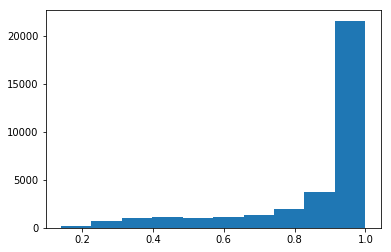

In [174]:
plt.hist(model.predict(X_train))

In [159]:
Y_pred1 = (model.predict(X_test)>0.5).astype(int)
print(accuracy_score(Y_test, Y_pred1))
confusion_matrix(Y_test, Y_pred1)

0.8522757519297312


array([[ 384,  283],
       [ 272, 2818]])

In [285]:
l1 = model.get_layer("layer1")
l1.get_weights()[0].ravel()

array([-0.02789835,  0.02168945,  0.01079839, ..., -0.02229493,
       -0.01450237, -0.04505375], dtype=float32)

(array([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        6.0000e+00, 4.0000e+01, 3.3980e+03, 1.8989e+04, 3.5773e+04,
        3.7403e+04, 2.0493e+04, 4.2600e+03, 3.7000e+01, 1.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00]),
 array([-1.        , -0.93333333, -0.86666667, -0.8       , -0.73333333,
        -0.66666667, -0.6       , -0.53333333, -0.46666667, -0.4       ,
        -0.33333333, -0.26666667, -0.2       , -0.13333333, -0.06666667,
         0.        ,  0.06666667,  0.13333333,  0.2       ,  0.26666667,
         0.33333333,  0.4       ,  0.46666667,  0.53333333,  0.6       ,
         0.66666667,  0.73333333,  0.8       ,  0.86666667,  0.93333333,
         1.        ]),
 <a list of 30 Patch objects>)

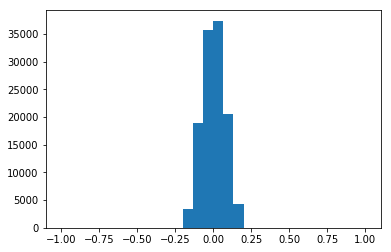

In [99]:
l1 = model.get_layer("layer1")
plt.hist(l1.get_weights()[0].ravel(), bins=30, range=(-1,1))

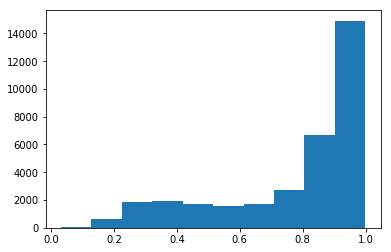

In [164]:
plt.hist(model.predict(X_train))
plt.show()

In [203]:
pred = model.predict(X_test)
idx = np.where(pred<0.3)[0]

In [174]:
for i in range(len(idx)):
    print(pred[i], Y_test[i])

[0.97772026] 1
[0.9541617] 1
[0.5386401] 0
[0.9818792] 1
[0.9157739] 0
[0.96501845] 1
[0.9708846] 1
[0.9781009] 1
[0.42925888] 0
[0.997959] 1
[0.5404831] 0
[0.9827959] 1
[0.7582309] 1
[0.8819169] 0
[0.9573313] 1
[0.959993] 1
[0.48295692] 0
[0.97830987] 1
[0.995999] 1
[0.5414268] 0
[0.83401334] 1
[0.51236796] 0
[0.9929508] 1
[0.91685] 1
[0.90754074] 1
[0.9852047] 1
[0.9879489] 1
[0.99886703] 1
[0.5496952] 1
[0.95478874] 1
[0.9839409] 1
[0.772484] 1
[0.9964713] 1
[0.98914206] 1
[0.9782548] 1
[0.96966076] 1
[0.9785876] 1
[0.68058294] 0
[0.99516016] 1
[0.9911753] 1
[0.98937434] 1
[0.8199292] 1
[0.8899329] 0
[0.6321105] 1
[0.98199743] 1
[0.95295465] 1
[0.9915103] 1
[0.862754] 1
[0.98961675] 1
[0.9313016] 0
[0.79055405] 1
[0.9465383] 1
[0.9994234] 1
[0.97542727] 1
[0.8631533] 0
[0.99776244] 1
[0.99757415] 1
[0.97010976] 1
[0.86313045] 1
[0.99683326] 1
[0.99865025] 1
[0.9983937] 1
[0.9874942] 1
[0.88709706] 1
[0.9496948] 0
[0.9882946] 1
[0.9689556] 1
[0.94108176] 1
[0.9836093] 1
[0.97141504] 